<h1><center> PathLinker Cytoscape automation example </center></h1>
<img src="http://apps.cytoscape.org/media/pathlinker/logo.png.png" alt="PathLinker Logo"><img src="http://apps.cytoscape.org/media/cyrest/logo300.png.png" alt="CyRest Logo">

## Requirments
* Java 8
* Cytoscape 3.6.0+
* cyREST 3.6.0+
* py2cytoscape 0.4.2+

## References used to create this script (Both came from idekerlab):
* [New_wrapper_api_sample](http://nbviewer.jupyter.org/github/idekerlab/py2cytoscape/blob/master/examples/New_wrapper_api_sample.ipynb)
* [basic1](http://nbviewer.jupyter.org/github/idekerlab/py2cytoscape/blob/master/examples/basic1.ipynb)

In [1]:
# necessary libraries and dependencies
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.style import StyleUtil

import networkx as nx
import pandas as pd
import json
import requests
from requests.status_codes import codes

In [2]:
# !!!!!!!!!!!!!!!!! Step 0: Start Cytoscape 3.6 with cyREST App !!!!!!!!!!!!!!!!!!!!!!!!!!
# Cytoscape must be running to use the automation features

# Step 1: create an instance of cyRest client
cy = CyRestClient()

# Reset the session
cy.session.delete()

## Create network using networkx

To create a network that PathLinker will run on, the example uses the graph-undir_human-interactome.txt. The file can be view and download in [here](https://github.com/Murali-group/PathLinker-Cytoscape/blob/master/src/test/resources/input/graph-undir_human-interactome.txt). <br>
You can lear more about the example file [here](http://bioinformatics.cs.vt.edu/~murali/supplements/2016-sys-bio-applications-pathlinker/).

In [3]:
# Step 2: Import/Create the network that PathLinker will run on

# create a new network by importing the data from a txt file using pandas
network_csv = pd.read_csv('../src/test/resources/input/graph-undir_human-interactome.txt', 
                          header=None, sep='\t', lineterminator='\n')

# initialize an empty undirected graph from networkx
nx_network = nx.Graph()

# fill the empty network with source, target, and corresponding edge weight
# from the data inside the network_csv
for row in network_csv.itertuples():
    nx_network.add_edge(row[1], row[2], weight=row[3])
    
# create the CyNetwork object from the networkx in CytoScape
cy_network = cy.network.create_from_networkx(nx_network, collection = 'Generated by NetworkX')

# obtain the CyNetwork object SUID
cy_network_suid = cy_network.get_id()

The network shown below will be generated in Cytoscape with the above code. Do notice that there are no visual style applied to the network, hence the reason of only a square in the center (all the other nodes are hidden behind the square).

Looking at the Edge Table in the Table Panel, the network consists of 'source' column, 'target' column, and <b>'weight' column</b>. The 'weight' column will be used for the <b>'edgeWeightColumnName"</b> input for running the PathLinker API function. 

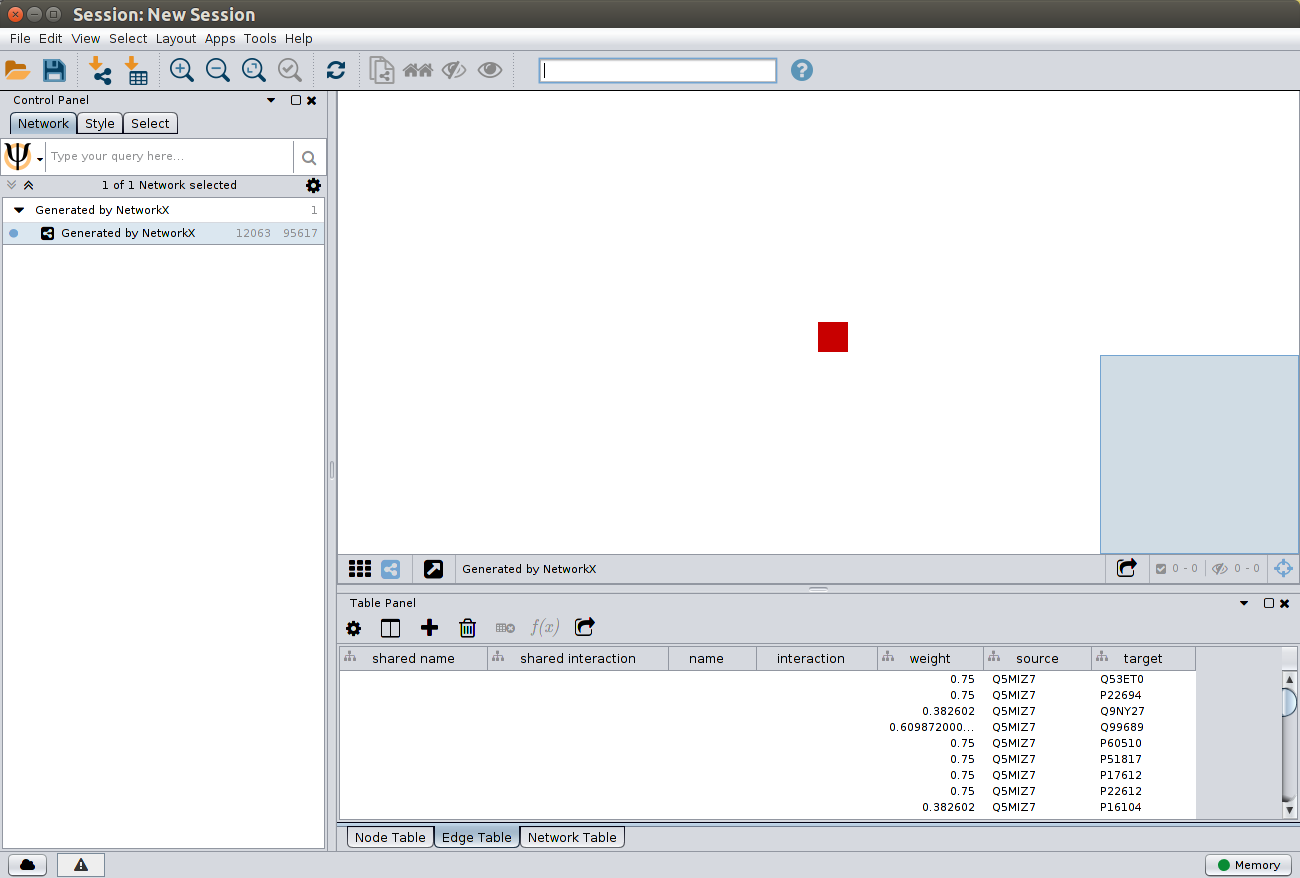

## Use PathLinker API function

PathLinker consist of one REST API Post function "runPathLinker".

### runPathLinker
POST function that takes as input a network SUID, sources, targets, and a set of parameters, computes the k shortest paths, generates a subnetwork (and view) containing those paths, and returns the computed paths and subnetwork/view SUIDs.

In [4]:
# Step 3: Construct input data to pass to PathLinker API function

# construct PathLinker input data for API request
input_data = {}
input_data["sources"] = "P35968 P00533 Q02763"
input_data["targets"] = "Q15797 Q14872 Q16236 P14859 P36956"
# input_data["allowSourcesTargetsInPaths"] = False           # optional parameter, default is set to False
# input_data["includeTiedPaths"] = False                     # optional parameter, default is set to False
input_data["k"] = 50
input_data["edgeWeightSetting"] = "PROBABILITIES"
input_data["edgePenalty"] = 1
input_data["edgeWeightColumnName"] = "weight"               # using the 'weight' column in the edge table
input_data["skipKSPSubgraphGeneration"] = False

# perform REST API call
headers = {'Content-Type': 'application/json', 'Accept': 'application/json'}

# construct REST API request url
url = "http://localhost:1234/pathlinker/v1.4/" + str(cy_network_suid) + "/runPathLinker"

# store request output
result_json = requests.request("POST", 
                          url,
                          data = json.dumps(input_data),
                          params = None,
                          headers = headers)



The KSP subnetwork shown below will be generated by running the runPathLinker function with above input.

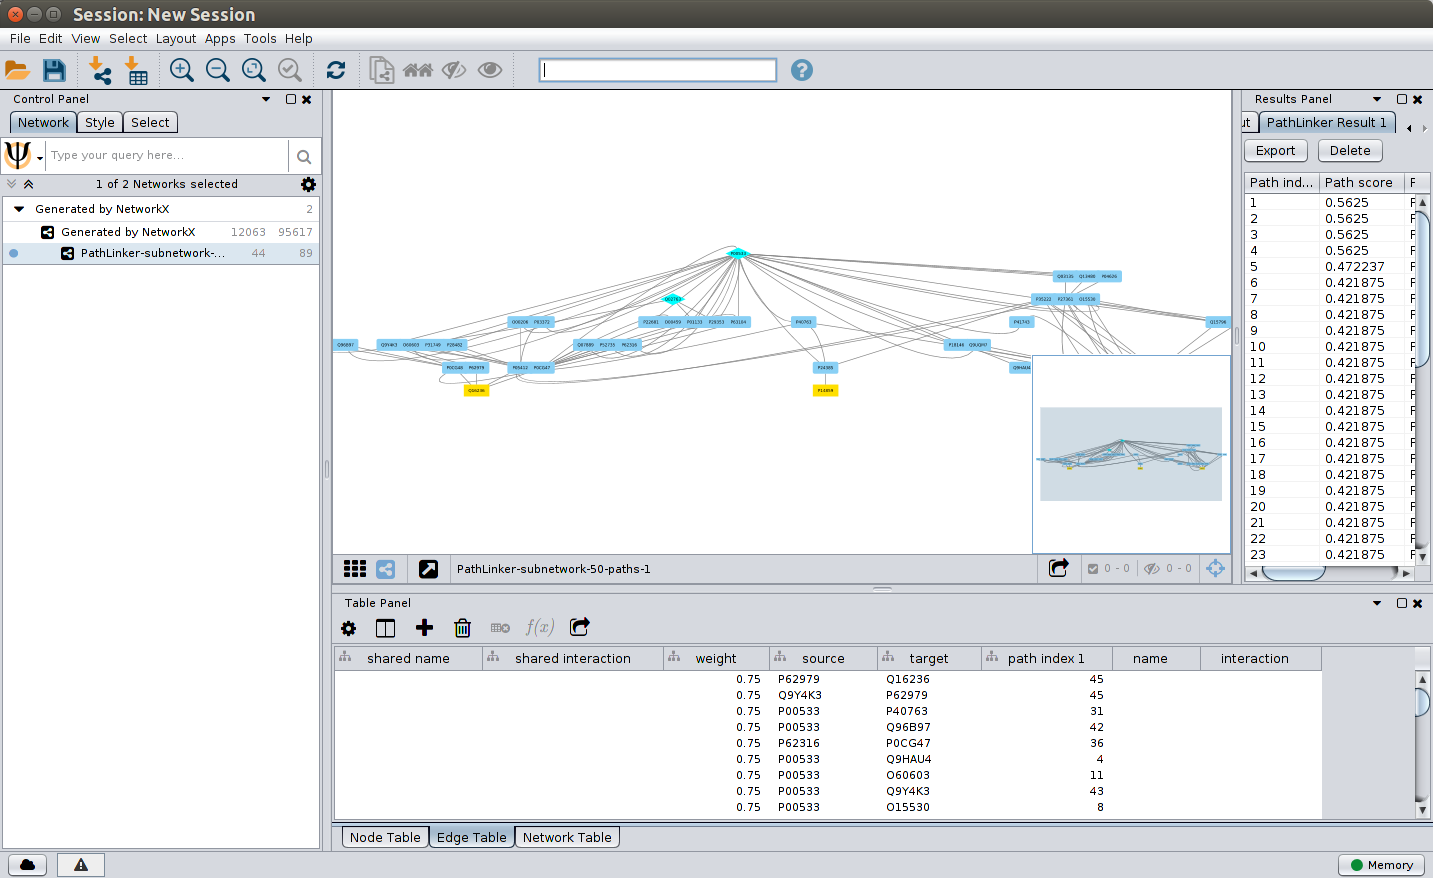

## runPathLinker output

the following section stores the ksp subnetwork/view references and prints out the path output returned by the runPathLinker function

In [5]:
# Step 4: Store result, parse, and print

parsed = json.loads(result_json.content)

print("runPathLinker Output:\n")

# if KSP subgraph is generated, then access the suid and references
if not input_data["skipKSPSubgraphGeneration"]:
    ksp_network_suid = parsed["kspSubNetworkSUID"]
    ksp_network_view_suid = parsed["kspSubNetworkViewSUID"]
    
    print("KSP subgraph SUID: ", ksp_network_suid)
    print("KSP subgraph SUID: ", ksp_network_view_suid)
    print("\n")
    
    # access network and network view references
    ksp_network_ref = cy.network.create(suid=ksp_network_suid)
    ksp_network_view_ref = ksp_network_ref.get_first_view()

# Access the paths generated by PathLinker
paths = parsed["paths"]

# print the first 10 paths out of 50 paths
for path in paths[:10]:
    print("path index:", path['pathIndex'])
    print("path score:", path['pathScore'])
    print("path:", " " * 5, "|".join(path['path']), "\n")

runPathLinker Output:

KSP subgraph SUID:  825595
KSP subgraph SUID:  825611


path index: 1
path score: 0.5625
path:       P00533|P0CG47|Q16236 

path index: 2
path score: 0.5625
path:       P00533|P24385|P14859 

path index: 3
path score: 0.5625
path:       P00533|P27361|Q15797 

path index: 4
path score: 0.5625
path:       P00533|Q9HAU4|Q15797 

path index: 5
path score: 0.472237
path:       P00533|Q13153|Q15797 

path index: 6
path score: 0.421875
path:       P00533|O00206|P05412|Q16236 

path index: 7
path score: 0.421875
path:       P00533|O00459|P0CG47|Q16236 

path index: 8
path score: 0.421875
path:       P00533|O15530|P84022|Q15797 

path index: 9
path score: 0.421875
path:       P00533|O15530|Q13485|Q15797 

path index: 10
path score: 0.421875
path:       P00533|O15530|Q15796|Q15797 



## Visualization using cytoscape.js and py2cytoscape

run the following section only if there exists ksp_network_ref and ksp_network_view_ref

In [6]:
import py2cytoscape.cytoscapejs as renderer

# visualize the network view using CytoScape.js
renderer.render(ksp_network_view_ref, 'Directed', background='radial-gradient(#FFFFFF 15%, #DDDDDD 105%)')
    

<IPython.core.display.Javascript object>

## Access and store the pdf image

run the following section only if there exists ksp_network_ref and ksp_network_view_ref

In [7]:
# pdf
ksp_network_pdf = ksp_network_ref.get_pdf()

f = open('ksp_network.pdf', 'wb')
f.write(ksp_network_pdf)
f.close()

from IPython.display import IFrame
IFrame('ksp_network.pdf', width=600, height=300)

## Show PNG image

run the following section only if there exists ksp_network_ref and ksp_network_view_ref

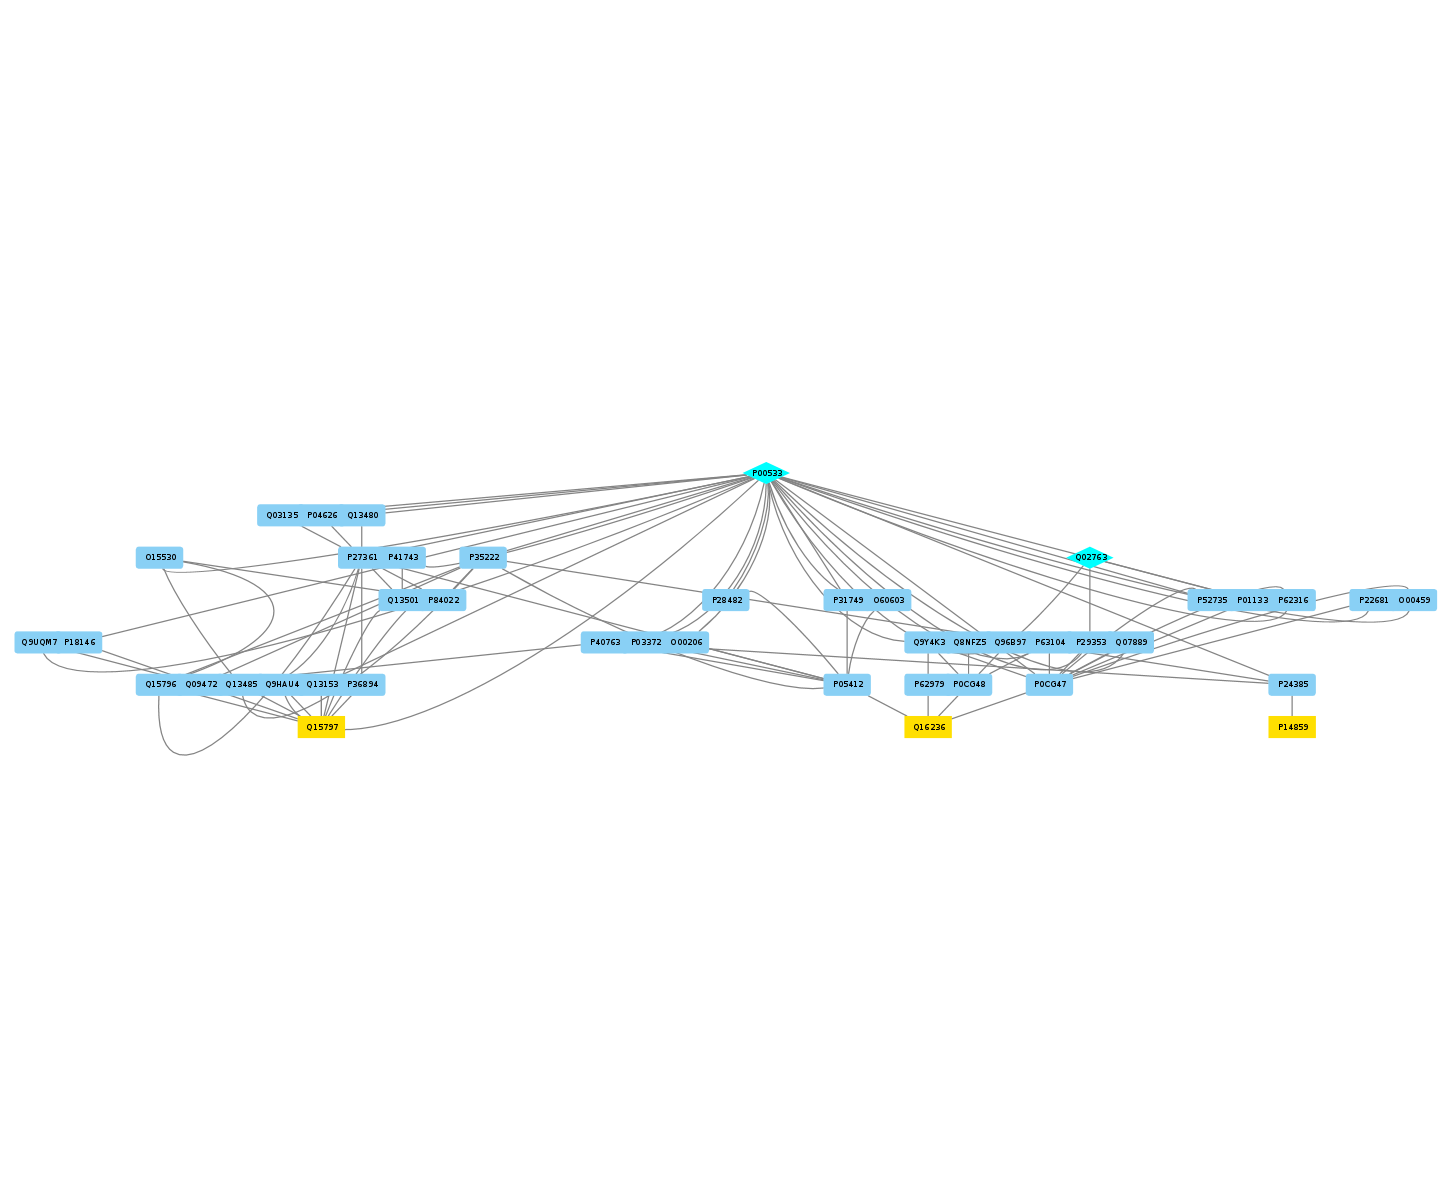

In [8]:
#png
ksp_network_png = ksp_network_ref.get_png()

from IPython.display import Image
Image(ksp_network_png)

## Show SVG image

run the following section only if there exists ksp_network_ref and ksp_network_view_ref

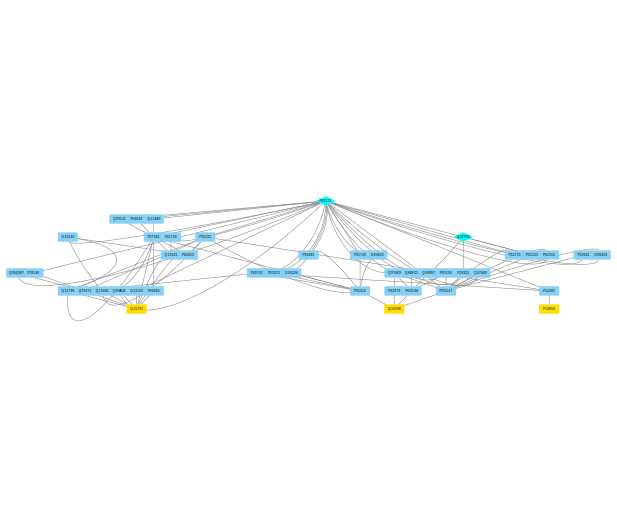

In [9]:
#svg
ksp_network_svg = ksp_network_ref.get_svg()

from IPython.display import SVG
SVG(ksp_network_svg)